In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow_addons.metrics import F1Score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from tensorflow.keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping

import logging
import json
import os
import dill

c:\Users\salah\.conda\envs\vision-transformer\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [56]:
def dump_json(data, json_file_path):
    with open(json_file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
        
def load_json(json_file_path):
    with open(json_file_path, 'r') as json_file:
        loaded_data = json.load(json_file)
    return loaded_data

In [61]:
def save_model(model, file_path): 
    dir_path = os.path.dirname(file_path)
    with open( file_path, "wb") as file_obj:
        dill.dump(obj, file_obj)
        

def load_model(file_path):
    with open(file_path, "rb") as file_obj:
        obj = dill.load(file_obj)
    return obj

In [69]:
def get_model_performance_metrics(model, images, labels):
    # Evaluating the model
    loss, accuracy = model.evaluate(images, labels)

    # Getting Precision, Recall, and F1 Score
    y_pred = model.predict(images)
    y_pred_labels = np.argmax(y_pred, axis=1)

    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, y_pred_labels, average='macro')
    performance = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }
    return performance

In [53]:
def save_model_logs(history,history_path):
    # saving logs
    logging.basicConfig(filename= history_path, level=logging.INFO)

    # Log training history
    for epoch, (loss, val_loss) in enumerate(zip(history.history['loss'], history.history['val_loss'])):
        logging.info(f"Epoch {epoch + 1}, Loss: {loss}, Val Loss {val_loss}")


In [42]:
def plot_log_function(history):
    plt.figure(figsize=(10,10))
    plt.plot(history.history['loss']) # tb
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [26]:
def random_transform(image):
    choice = random.randint(0, 5)

    rows, cols, _ = image.shape

    if choice == 0: # Translation
        tx, ty = random.randint(-20, 20), random.randint(-20, 20)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        return cv2.warpAffine(image, M, (cols, rows))

    elif choice == 1: # Rotation
        angle = random.randint(-30, 30)
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        return cv2.warpAffine(image, M, (cols, rows))

    elif choice == 2: # Scaling
        scale_factor = random.uniform(0.8, 1.2)
        new_rows, new_cols = int(rows * scale_factor), int(cols * scale_factor)
        return cv2.resize(image, (new_cols, new_rows))

    elif choice == 3: # Skewing
        pts1 = np.float32([[5,5],[20,5],[5,20]])
        pt1 = 5+10*np.random.uniform()-10/2
        pt2 = 20+10*np.random.uniform()-10/2
        pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
        M = cv2.getAffineTransform(pts1,pts2)
        return cv2.warpAffine(image, M, (cols, rows))

    elif choice == 4: # Perspective distortion
        pts1 = np.float32([[5,5],[20,5],[5,20],[20,20]])
        pts2 = np.float32([[0,0],[20,5],[5,20],[20,20]])
        M = cv2.getPerspectiveTransform(pts1,pts2)
        return cv2.warpPerspective(image, M, (cols, rows))

    else: # Pincushion distortion
        distortion = np.float32([1, 1, 0, 0])
        camera_matrix = np.eye(3)
        return cv2.undistort(image, camera_matrix, distortion)


In [54]:
def get_transformed_test_images(test_images):
    transformed_test_images = []
    for img in test_images:
        transformed_img = random_transform(img)
        transformed_test_images.append(transformed_img)

    # resizing transformed_test_images into (32, 32)
    new_shape = (32, 32)
    transformed_test_images = np.array([cv2.resize(img, new_shape).reshape(32, 32, 1) for img in transformed_test_images])

    # Checking for shape consistency
    
    good_shape = test_images[0].shape
    for i, img in enumerate(transformed_test_images):
        if img.shape != good_shape:
            print(f"Inconsistent shape at index {i}: expected {good_shape}, but got {img.shape}")
    return transformed_test_images

In [5]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [6]:
# Preprocess images
new_shape = (32, 32)
train_images = np.array([cv2.resize(img, new_shape) for img in train_images])
test_images = np.array([cv2.resize(img, new_shape) for img in test_images])

train_images, test_images = train_images / 255.0, test_images / 255.0
train_images = train_images[..., tf.newaxis].astype("float32")
test_images = test_images[..., tf.newaxis].astype("float32")

In [7]:
# creating validation images val_images
val_size = int(len(train_labels)*0.25)

train_images , val_images= train_images[val_size:], train_images[:val_size]
print("train_images size: ", train_images.shape, " and val_images size: ", val_images.shape)

train_labels , val_labels= train_labels[val_size:], train_labels[:val_size]
print("train_labels size: ", train_labels.shape, " and val_labels size: ", val_labels.shape)

train_images size:  (45000, 32, 32, 1)  and val_images size:  (15000, 32, 32, 1)
train_labels size:  (45000,)  and val_labels size:  (15000,)


In [8]:
hyperparameters={
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 12,
    "optimizer":"adam",
    'early_stopping_patience':3
}
# Build the ViT model
input_shape = (*new_shape, 1)
patch_size = 4
num_heads = 2
num_patches = (new_shape[0] // patch_size) * (new_shape[1] // patch_size)
projection_dim = 32
num_transformer_layers = 2
mlp_head_units = [64, 32]

inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(3, (3, 3), padding="same")(inputs)  # Convert to 3 channels
x = tf.keras.layers.Rescaling(1.0 / 255)(x)  # Rescale
x = tf.keras.layers.Conv2D(32, (patch_size, patch_size), strides=patch_size)(x)
x = tf.keras.layers.Reshape((num_patches, 32))(x)

for _ in range(num_transformer_layers):
    x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    attention_output = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)
    x2 = tf.keras.layers.Add()([attention_output, x])
    x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = tf.keras.layers.Conv1D(64, 2, padding="same", activation="relu")(x3)
    x3 = tf.keras.layers.Dropout(0.1)(x3)
    x3 = tf.keras.layers.Conv1D(32, 2, padding="same")(x3)
    x = tf.keras.layers.Add()([x3, x2])

x = tf.keras.layers.GlobalAveragePooling1D()(x)
for dim in mlp_head_units:
    x = tf.keras.layers.Dense(dim, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [9]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model with early stopping
history = model.fit(train_images, train_labels, validation_data = (val_images, val_labels), verbose = 1, epochs=12, batch_size=32, callbacks=[early_stopping])

Epoch 1/12
1407/1407 [==============================] - 162s 105ms/step - loss: 2.2240 - accuracy: 0.1409 - val_loss: 1.7792 - val_accuracy: 0.3103
Epoch 2/12
1407/1407 [==============================] - 154s 109ms/step - loss: 1.3065 - accuracy: 0.5023 - val_loss: 0.7931 - val_accuracy: 0.7301
Epoch 3/12
1407/1407 [==============================] - 137s 98ms/step - loss: 0.7211 - accuracy: 0.7648 - val_loss: 0.4742 - val_accuracy: 0.8470
Epoch 4/12
1407/1407 [==============================] - 139s 99ms/step - loss: 0.5199 - accuracy: 0.8358 - val_loss: 0.3947 - val_accuracy: 0.8720
Epoch 5/12
1407/1407 [==============================] - 135s 96ms/step - loss: 0.4365 - accuracy: 0.8648 - val_loss: 0.3114 - val_accuracy: 0.8998
Epoch 6/12
1407/1407 [==============================] - 128s 91ms/step - loss: 0.3841 - accuracy: 0.8802 - val_loss: 0.2708 - val_accuracy: 0.9127
Epoch 7/12
1407/1407 [==============================] - 124s 88ms/step - loss: 0.3477 - accuracy: 0.8925 - val_loss:

In [32]:
#saving model
path = os.path.join(os.path.dirname(os.getcwd()),'experiments','multi_headed_attention_mnist_dataset', 'models/model_weights.h5')
dump_model(model, path)

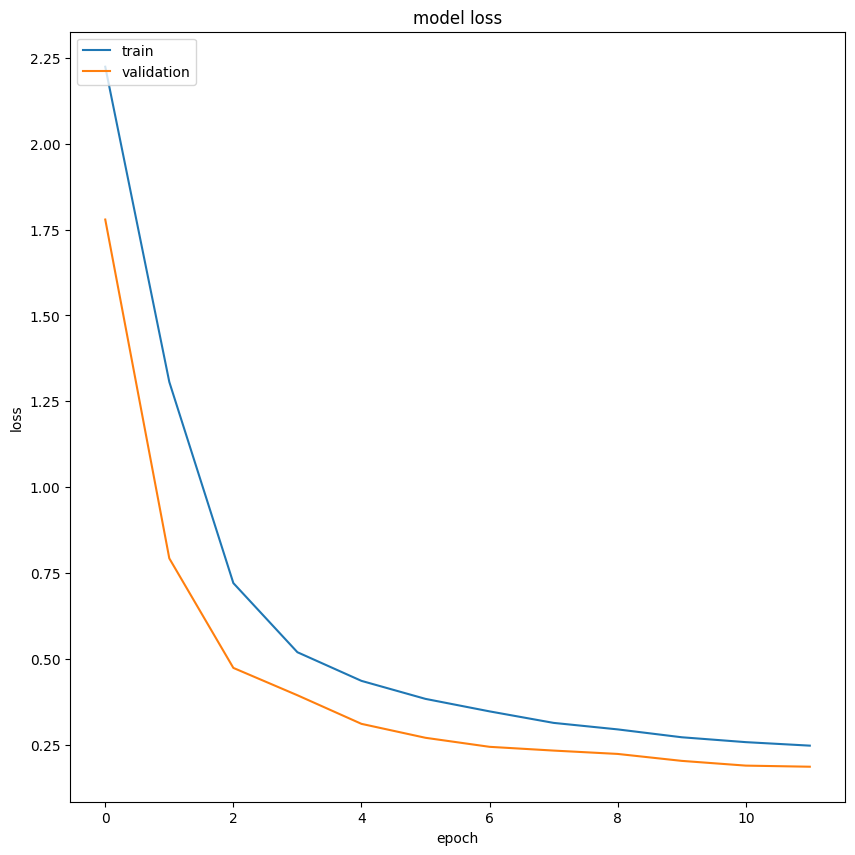

In [41]:
#checking the performance on taining_data
plot_log_function(history)

In [39]:
history_path = os.path.join(os.path.dirname(os.getcwd()),'experiments','multi_headed_attention_mnist_dataset', 'history.log')
save_model_logs(history,history_path)

In [63]:
path = os.path.join(os.path.dirname(os.getcwd()),'experiments','multi_headed_attention_mnist_dataset', 'model.pkl')

model = load_model(path)

In [66]:
# saving model architecture and hypermarameters
model_info = {
    "model_name": "Vision Transformer"
}
model_info["hyperparameters"] = hyperparameters
model_info["model_architecture"] = model.to_json()
model_info["model_architecture"]  = json.loads(model_info["model_architecture"] )

path = os.path.join(os.path.dirname(os.getcwd()),'experiments','multi_headed_attention_mnist_dataset', 'mode_architecture.json')
dump_json(model_info, path )
print(model_info)

{'model_name': 'Vision Transformer', 'hyperparameters': {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 12, 'optimizer': 'adam', 'early_stopping_patience': 3}, 'model_architecture': {'class_name': 'Functional', 'config': {'name': 'model', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 32, 32, 1], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': 'float32', 'filters': 3, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'kera

In [29]:
transformed_test_images= get_transformed_test_images(test_images)

In [70]:
#saving model performance metrics
model_performance_metrics = {
    "model_name": "Vision Transformer"
}
model_performance_metrics["train_images_performance_metrics"] = get_model_performance_metrics(model,train_images, train_labels)
model_performance_metrics["validation_images_performance_metrics"] = get_model_performance_metrics(model,val_images, val_labels)
model_performance_metrics["test_images_performance_metrics"] = get_model_performance_metrics(model, test_images, test_labels)
model_performance_metrics["transformed_test_images_performance_metrics"] = get_model_performance_metrics(model, transformed_test_images, test_labels)


path = os.path.join(os.path.dirname(os.getcwd()),'experiments','multi_headed_attention_mnist_dataset', 'mode_performance_metrics.json')
dump_json(model_performance_metrics, path)
print(model_performance_metrics)

313/313 [==============================] - 9s 29ms/step
{'model_name': 'Vision Transformer', 'train_images_performance_metrics': {'accuracy': 0.9430444240570068, 'precision': 0.9436927070787323, 'recall': 0.9420877265489679, 'f1_score': 0.9422721891708056}, 'validation_images_performance_metrics': {'accuracy': 0.9435333609580994, 'precision': 0.9438024712517473, 'recall': 0.9425949696819353, 'f1_score': 0.9427020690781334}, 'test_images_performance_metrics': {'accuracy': 0.9429000020027161, 'precision': 0.9440102443234146, 'recall': 0.9418122581187565, 'f1_score': 0.9421103523277411}, 'transformed_test_images_performance_metrics': {'accuracy': 0.6693999767303467, 'precision': 0.7721902514267633, 'recall': 0.6645088858253737, 'f1_score': 0.6914443995671273}}
